In [54]:
import numpy as np
import matplotlib.pyplot as plt
from general_functions import *
from scipy.integrate import solve_ivp

In [61]:
N, S, M, mu = 2, 3, 3, 0.1
mu_pos, mu_neg = mu, -mu

In [62]:
def get_index(i, s, m, N=N, S=S, M=M):
    return i*M*S + s*M + m

def get_ism(index, N=N, S=S, M=M):
    i = index // (M*S)
    s = index % (M*S) // M
    m = index % (M*S) % M
    return i, s, m

def phi_to_y(phi, N=N, S=S, M=M):
    y = np.empty(N*S*M)
    for alpha in range(N*S*M):
        y[alpha] = phi[get_ism(alpha, N=N, S=S, M=M)]
    return y

def y_to_phi(y, N=N, S=S, M=M):
    phi = np.empty((N,S,M))
    for alpha in range(N*S*M):
        phi[get_ism(alpha, N=N, S=S, M=M)] = y[alpha]
    return phi

def func(t, phi, mu, N, S, M):
    
    phi_dot = np.zeros(N*S*M)

    for alpha in np.arange(N*S*M):
        i,s,m = get_ism(alpha, N=N, S=S, M=M)
        sum_of_terms = 0

        for j in range(N):
            if j==i: continue # omit the j=i case

            for s_ in range(S):
                delta_ss = 1 if s_==s else 0
                sum_denominator = 0
                for m_ in range(M): sum_denominator += phi[get_index(j, s_, m_, N=N, S=S, M=M)]

                sum_of_terms += mu/(N*(N-1)*M) * phi[get_index(i,s_,m, N=N, S=S, M=M)]**2 * (1 - phi[get_index(i,s_,m, N=N, S=S, M=M)]) * \
                                (2 * phi[get_index(j,s_,m, N=N, S=S, M=M)] / sum_denominator - 1) * (delta_ss - phi[alpha])

        phi_dot[alpha] = sum_of_terms 
    
    return phi_dot

In [66]:
def deterministic_predictions(N=2, S=3, M=3, mu=mu, tf=5000, focused=False, n_epsilons=30):

    fig, ax = plt.subplots()

    epsilons = np.linspace(0, 1/(S-1), 11) # unphysical beyond 1/(S-1)
    if focused: epsilons = np.linspace(1/S - 0.05, 1/S + 0.05, n_epsilons+1)
    opt_grammar = optimal_grammar(N=N, S=S, M=M)
    t_eval = np.arange(0, tf+100, 100)
    eval_times = len(t_eval)

    for eps in epsilons:

        phi_init = suboptimal_grammar(opt_grammar, N=N, S=S, M=M, epsilon=eps, method='uniform')

        # grid_display(phi_init, N, S, M, eps)

        y0 = phi_to_y(phi_init, N=N, S=S, M=M)
        sol = solve_ivp(func, t_span=[0, tf], t_eval=t_eval, y0=y0, method='RK45', vectorized=True, args=(mu, N, M, S))

        y_final = sol.y[:,-1]
        phi_final = y_to_phi(y_final, N=N, S=S, M=M)

        diffs = []
        for t in range(eval_times): diffs.append(difference(y_to_phi(sol.y[:,t], N=N, S=S, M=M), opt_grammar, N, S, M, normalised=True)) 
        # normalise the difference: 0 = no difference, 1 = completely different but satisfying the constraint

        print(f'epsilon = {eps:.2f} --- diff = {diffs[-1]:9.6f}', end='\r')

        if focused: ax.plot(t_eval, diffs, alpha=0.3, color='gray')
        else: ax.plot(t_eval, diffs, label=f'$\epsilon = {eps:.2f}$', alpha=0.5)

    # stochastic_diffs = run_model_diffs(opt_grammar, tf, t_eval, N, S, M)
    # ax.plot(t_eval, stochastic_diffs, 'k', label='stochastic model')

    ax.set_xlabel('integration time')
    ax.set_ylabel('difference to optimal grammar')
    if focused: 
        title = f'$(N,S,M,\mu) = ({N},{S},{M},{mu})$ | ${min(epsilons):.2f} < \epsilon < {max(epsilons):.2f}$'
    else:
        ax.legend()
        title = f'$(N,S,M,\mu) = ({N},{S},{M},{mu})$'
    ax.set_title(title)

    plt.show()

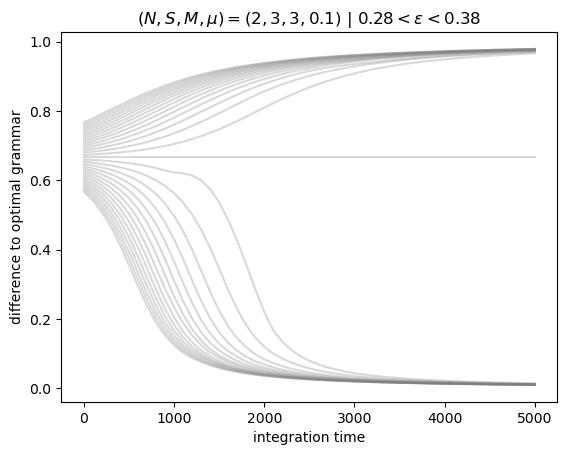

In [67]:
deterministic_predictions(N, S, M, mu, focused=True)

In [48]:
def stoch_fluctuations(n_runs=5, max_steps=10_000, focused=False, n_epsilons=30, save_phis=False):

    fig, ax = plt.subplots()

    epsilons = np.linspace(0, 1/(S-1), 11)
    if focused: 
        epsilons = np.linspace(1/S - 0.05, 1/S + 0.05, n_epsilons+1)
    opt_grammar = optimal_grammar(N=N, S=S, M=M)
    increment = 200
    timesteps = np.arange(0, max_steps + increment, increment)

    if save_phis: 
        saved_phis = [] # for display
        top, middle, bottom = False, False, False

    for i, eps in enumerate(epsilons):

        phi_init = suboptimal_grammar(opt_grammar, N=N, S=S, M=M, epsilon=eps, method='uniform')
        all_differences = []
        
        for run in range(n_runs):

            differences = []
            phi = phi_init.copy()

            for step in range(max_steps+1):

                speaker, listener = choose_agents(N)
                intend = choose_meaning(M)
                signal = choose_signal(S, prob_array=phi[speaker,:,intend])
                infer = infer_meaning(M, prob_array=phi[listener,signal,:] / np.sum(phi[listener,signal,:]))
                feedback = get_feedback(mu_pos, mu_neg, intend, infer, speaker, listener, method=None, social_ladder=None)

                phi[speaker,signal,intend] += feedback * U(phi[speaker,signal,intend])
                phi[speaker,:,intend] /= np.sum(phi[speaker,:,intend])

                if step in timesteps:

                    differences.append(difference(opt_grammar, phi, N, S, M, normalised=True))

                    # if equilibrium(phi, N, S, M): break

            print(f'eps {eps:.3f}, run {run} complete', end='\r')

            if save_phis:

                # save example phis for display for the three cases
                if differences[-1] > .9 and top == False:
                    top_phi = phi
                    top = True
                if 0.6 < differences[-1] < 0.7 and middle == False:
                    middle_phi = phi
                    middle = True
                if differences[-1] < .1 and bottom == False:
                    bottom_phi = phi
                    bottom = True

            if focused: 
                
                # highlight the curves where the stochastic fluctuations result 
                # in a different trajectory to the deterministic prediction
                
                if   eps < 1/S and differences[-1] > 0.9:
                    color = 'red'
                elif eps > 1/S and differences[-1] < 0.1:
                    color = 'blue'
                else: color = 'gray'
                ax.plot(timesteps, differences, alpha=0.3, color=color)

            all_differences.append(differences)

        if focused == False:
            mean_differences = np.mean(all_differences, axis=0)
            ax.plot(timesteps, mean_differences, alpha=0.5, label=f'$\epsilon = {eps:.2f}$')
        
    ax.set_xlabel('conversations')
    ax.set_ylabel('difference to optimal grammar')
    if focused == False: 
        ax.legend()
        title = f'$(N,S,M,\mu) = ({N},{S},{M},{mu})$ | {n_runs} runs per $\epsilon$'
    else: 
        title = f'$(N,S,M,\mu) = ({N},{S},{M},{mu})$ | ${min(epsilons):.2f} < \epsilon < {max(epsilons):.2f}$'
        y = difference(opt_grammar, suboptimal_grammar(opt_grammar, N, S, M, epsilon=1/S, method='uniform'), N, S, M, normalised=True)
        ax.axhline(y=y, lw=0.5, color='k', ls='dashed')
    ax.set_title(title)

    if save_phis:

        saved_phis = [top_phi, middle_phi, bottom_phi]
        fig, axs = plt.subplots(nrows=3)
        for i, ax in enumerate(axs):
            ax.imshow(saved_phis[i][0], cmap='magma', vmin=0, vmax=1)
            ax.axis('off')

    plt.show()

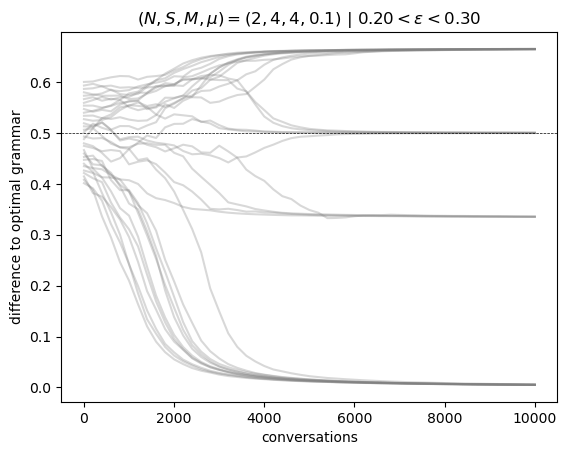

In [50]:
stoch_fluctuations(n_runs=1, max_steps=10000, focused=True, n_epsilons=30)

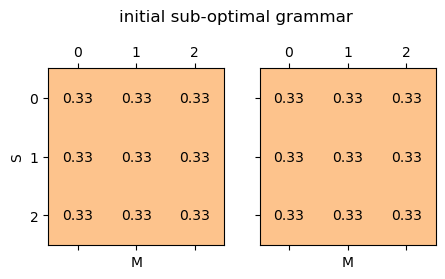

0.6666666666666666


In [37]:
N, S, M = 2, 3, 3
phi = suboptimal_grammar(optimal_grammar(N, S, M), N, S, M, epsilon=1/S, method='uniform')
grid_display(phi, N, S, M)
print(difference(phi, optimal_grammar(N, S, M), N, S, M, normalised=True))